In [1]:
import json
from heapq import heappush, heappop
import matplotlib.pyplot as plt
import gpxpy

from gradient import gradient, lowess_smooth, window_smooth, handle_outliers, savgol_smooth

STRAVA_COLOR = '#fc4c02'

In [1]:
def raw_gradients(filename):
    gpx = gpxpy.parse(open(filename, "r"))
    trackpoints = gpx.tracks[0].segments[0].points
    data = []
    last_point = None
    for point in trackpoints:
        data.append(gradient(point, last_point))
        last_point = point
    # linear extrapolation
    data = data[1:]
    data.insert(0, 2 * data[0] - data[1]) 
    return data

def avg_abs_deviation(truth, test):
    total = 0
    for ii in range(len(truth)):
        total += abs(truth[ii] - test[ii])
    return total / len(truth)

def optimize_scale_factor(truth, test):
    value = 1
    delta = 0.001
    d = avg_abs_deviation(truth, test)
    last_d = d
    while d <= last_d:
        last_d = d
        value += delta
        d = avg_abs_deviation(truth, [ii * value for ii in test])
    return value

def plot(title, truth, test, deviation, scale, rows, columns, idx):
    x_axis = [ii for ii in range(len(truth))]
    linewidth = .5
    plt.subplot(rows, columns, idx)
    plt.plot(x_axis, truth, label='truth', linewidth=linewidth, color=STRAVA_COLOR)
    plt.plot(x_axis, test, label='test', linewidth=linewidth)
    plt.ylim((-15,15))
    plt.title(f'{title} | deviation={round(deviation, 3)} | scale={round(scale, 3)}')
    # plt.title(f'mean absolute deviation: {deviation}')

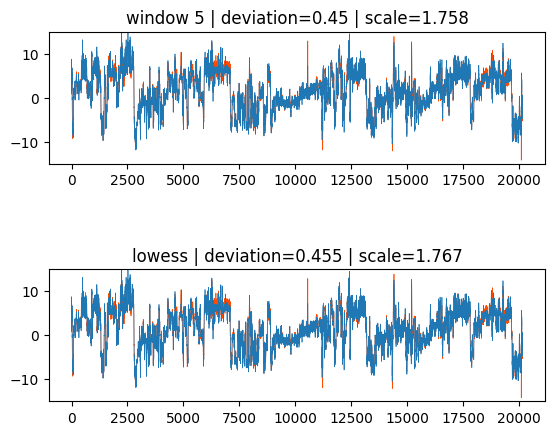

In [1]:
gpx_filename = 'todo_replace.gpx'
truth_filename = 'todo_replace.json' # list[float]
# you can find a JSON array of your Strava activity's gradients by navigating 
# to https://www.strava.com/activities/{activity_id}/analysis and inspecting 
# the Network tab of Developer Tools. Look for requets to the streams? endpoint. 
# If you don't see `grade_smooth` in the response, you may need to refresh the page.

raw = raw_gradients(gpx_filename)
base = handle_outliers(raw)
truth_gradients = json.load(open(truth_filename, 'r'))

sample = [
    ('raw', raw),
    ('cleaned and scaled', base),
    ('window 5', window_smooth(base, 5)),
    ('lowess', lowess_smooth(base, 0.0005, 1)),
    ('savgol', savgol_smooth(base)),
]

results = []
for title, test in sample:
    if test == raw:
        scale_factor = 1
    else:
        scale_factor = optimize_scale_factor(truth_gradients, test)
        test = [ii * scale_factor for ii in test] 
    deviation = avg_abs_deviation(truth_gradients, test)
    heappush(results, [deviation, title, scale_factor, test])

# rows = len(results)
rows = 2
columns = 1
ii = 1
while results and ii < rows + 1:
    deviation, title, scale_factor, result = heappop(results)
    plot(title, truth_gradients, test, deviation, scale_factor, rows, columns, ii)
    ii += 1

plt.subplots_adjust(hspace=0.8) # adjust vertical space between subplots
plt.show()